# Opis środowiska: `DartThrowEnv`
### Autorzy: Urszula Kostuch, Wojciech Łabędź

## Cel gry
Celem projektu było stworzenie własnego środowiska typu Gymnasium, zaprogramowanie agenta uczącego się rozwiązywać zdefiniowany problem oraz przeprowadzenie treningu i wizualizacji wyników. W tym przypadku zaprojektowane środowisko symuluje rzucanie rzutkami do tarczy, a agent ma za zadanie nauczyć się trafiać jak najbliżej środka. Tarcza jest podzielona na kilka stref punktowych, a dokładność rzutu decyduje o liczbie uzyskanych punktów.

## Parametry środowiska

### Przestrzeń akcji (`action_space`)

Agent może wybierać dowolny punkt na płaszczyźnie 2D w zakresie:

- `x ∈ [-1.5, 1.5]`
- `y ∈ [-1.5, 1.5]`

Jest to przestrzeń ciągła typu `Box(2,)`, czyli agent ma swobodę celowania w dowolnym kierunku w określonym promieniu.

### Przestrzeń obserwacji (`observation_space`)

Obserwacja ma postać stałego wektora:

- `obs = [0.0]`

Stan jest nieistotny dla samego problemu — gra jest bezstanowa (stateless), ponieważ jedynym istotnym aspektem jest akcja (rzut).

---

## Tarcza i nagrody

Tarcza podzielona jest na cztery strefy nagród zależnie od odległości `dist` od środka (0,0):

| Promień od środka | Nagroda  | Kolor (wizualizacja) |
|--------------------|----------|-----------------------|
| `dist < 0.3`       | `+10.0`  | Niebieski             |
| `dist < 0.6`       | `+5.0`   | Żółty                 |
| `dist < 1.2`       | `+1.0`   | Jasnozielony          |
| `dist ≥ 1.2`       | `-10.0`  | Poza tarczą           |

Te wartości odpowiadają zmiennym:
```python
self.radius_10 = self.max_throw_range * (1 / 5)  
self.radius_5 = self.max_throw_range * (2 / 5)   
self.radius_1 = self.max_throw_range * (4 / 5)   

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')


class DartThrowEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.max_throw_range = 1.5
        self.max_steps = 1
        self.current_step = 0

        self.action_space = spaces.Box(
            low=np.array([-self.max_throw_range, -self.max_throw_range]),
            high=np.array([self.max_throw_range, self.max_throw_range]),
            dtype=np.float32
        )

        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)

        self.radius_10 = self.max_throw_range * (1 / 5)  # 0.3
        self.radius_5 = self.max_throw_range * (2 / 5)   # 0.6
        self.radius_1 = self.max_throw_range * (4 / 5)   # 1.2

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        return np.array([0.0], dtype=np.float32), {}

    def step(self, action):
        self.current_step += 1
        done = True

        x, y = action
        dist = np.sqrt(x ** 2 + y ** 2)

        if dist < self.radius_10:
            reward = 10.0
        elif dist < self.radius_5:
            reward = 5.0
        elif dist < self.radius_1:
            reward = 1.0
        else:
            reward = -10.0

        obs = np.array([0.0], dtype=np.float32)
        return obs, reward, done, False, {}

## Algorytm uczenia: Deep Q-Learning (DQN)
Do nauki agenta zastosowano prosty Deep Q-Learning, w którym wartości Q są przewidywane przez jednowarstwową sieć neuronową.
Wszystkie możliwe akcje są z góry określone w siatce 100×100 punktów na płaszczyźnie [-1, 1], co daje 10 000 możliwych rzutów.

Aby uniknąć przeciążenia jednej akcji, każdy punkt może być użyty maksymalnie 4 razy w jednym epizodzie. Jeśli akcja została wykorzystana, agent wybiera inną z kolejnych najlepszych.

## Sieć neuronowa (`QNetwork`)

Architektura agenta została oparta na prostej sieci neuronowej, której wejściem jest wektor stanu (`state`), a wyjściem – wektor wartości dla wszystkich możliwych akcji (w tym przypadku punktów z siatki `action_grid`):

```python
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [2]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.model(x)

## Funkcje wizualizacyjne

### `visualize_dartboard_cv2(env, throws=[], wait_time=1000)`

Ta funkcja wizualizuje tarczę do rzutek oraz pozycje rzutów za pomocą biblioteki OpenCV.

- Tworzy obraz (`img`) o wymiarach 500×500 pikseli.
- Rysuje trzy strefy tarczy jako wypełnione okręgi:
  - Niebieski (10 pkt)
  - Żółty (5 pkt)
  - Jasnozielony (1 pkt)
- Rzuty przekazane w liście `throws` są nanoszone jako czerwone punkty.
- Obraz jest wyświetlany w oknie OpenCV przez określony czas (`wait_time` w milisekundach), po czym okno jest zamykane.


In [3]:
def visualize_dartboard_cv2(env, throws=[], wait_time=1000):
    size = 500
    center = size // 2
    scale = center / env.max_throw_range
    img = np.ones((size, size, 3), dtype=np.uint8) * 255

    def draw_circle(radius, color):
        r = int(radius * scale)
        cv2.circle(img, (center, center), r, color, -1)

    draw_circle(env.radius_1, (200, 255, 200))  
    draw_circle(env.radius_5, (0, 255, 255))    
    draw_circle(env.radius_10, (255, 0, 0))     

    for throw in throws:
        x, y = throw
        px = int(center + x * scale)
        py = int(center - y * scale)
        cv2.circle(img, (px, py), 4, (0, 0, 255), -1)

    cv2.imshow("Tarcza", img)
    cv2.waitKey(wait_time)
    cv2.destroyAllWindows()

### `visualize_dartboard_matplotlib(env, throws=[])`

Alternatywna wersja wizualizacji oparta na bibliotece Matplotlib.

- Tworzy wykres w układzie współrzędnych (0,0) jako środek tarczy.
- Rysuje trzy strefy jako kolorowe okręgi (`Circle`), oznaczone legendą:
  - Niebieski (1 pkt)
  - Żółty (5 pkt)
  - Jasnozielony (10 pkt)
- Rzuty z listy `throws` są oznaczone czerwonymi kropkami.

In [4]:
def visualize_dartboard_matplotlib(env, throws=[]):
    fig, ax = plt.subplots(figsize=(6, 6))

    dartboard = [
        (1.2, 'lightgreen', '10 pkt', 1),
        (0.6, 'yellow', '5 pkt', 2),
        (0.3, 'blue', '1 pkt', 3),
    ]

    for radius, color, label, z in dartboard:
        circle = Circle((0, 0), radius, color=color, label=label, zorder=z)
        ax.add_patch(circle)

    throws = np.array(throws)
    if len(throws) > 0:
        ax.plot(throws[:, 0], throws[:, 1], 'ro', label='Rzuty', zorder=4)

    ax.set_xlim(-env.max_throw_range, env.max_throw_range)
    ax.set_ylim(-env.max_throw_range, env.max_throw_range)
    ax.set_aspect('equal')
    ax.set_title("Tarcza do rzutek")
    ax.legend()
    ax.grid(True)
    plt.show()


# Trening agenta w środowisku DartThrowEnv

Poniżej trenujemy agenta DQN (Deep Q-Network), który uczy się trafiać w środek tarczy. Agent nie rzuca dowolnie – jego możliwe ruchy ograniczone są do **siatki rzutów** (action grid) o rozmiarze **100×100 punktów** w przestrzeni od `(-1, -1)` do `(1, 1)`.

Każdy punkt tej siatki to wektor `[x, y]`, który agent może wybrać jako rzut.

Używamy standardowego DQN z siecią neuronową jako funkcją Q. Agent:
- wybiera rzuty,
- obserwuje nagrody,
- i uczy się, które rzuty są opłacalne.

In [5]:
env = DartThrowEnv()

action_grid = np.array([[x, y] for x in np.linspace(-1, 1, 100)
                               for y in np.linspace(-1, 1, 100)])
action_size = len(action_grid)

learning_rate = 0.01
discount_factor = 0.9
epsilon = 1.0
epsilon_min = 0.05
epsilon_decay = 0.99
num_episodes = 400
num_throws_per_episode = 20

state_size = env.observation_space.shape[0]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_network = QNetwork(state_size, action_size).to(device)  
optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

rewards_dqn = []

## Pętla treningowa agenta DQN

W tej części agent gra przez wiele epizodów i uczy się, które rzuty są najbardziej opłacalne. Każdy epizod to osobna gra (20 rzutów). W środku epizodu agent przechodzi przez następujące kroki:

### 1. Reset środowiska
Na początku każdego epizodu resetujemy stan środowiska (`env.reset()`), zapisujemy aktualny stan i przygotowujemy zmienne do śledzenia postępów (np. suma nagród, lista rzutów).

### 2. Wybór akcji – eksploracja vs eksploatacja
- Jeśli `epsilon` jest wysokie (np. 1.0 na początku), agent rzuca losowo (eksploruje nowe możliwości).
- Jeśli `epsilon` jest niskie, agent wybiera najlepszy znany rzut na podstawie wartości Q przewidzianych przez sieć. Z każdym epizodem zmniejszamy wartość `epsilon`, tak że z czasem agent zaczyna ufać swoim przewidywaniom. Co epizod zmniejszamy wartość epsilona o 1% ustalając jednak minimalną wartość na 5% tak by agent cały czas miał możliwość eksplorowania.

### 3. Unikanie powtarzania rzutów
Każdy punkt na siatce rzutów (`action_grid`) może być wybrany maksymalnie 4 razy w jednym epizodzie. Dzięki temu agent musi szukać innych dobrych punktów.

Jeśli dany rzut był już wykonany 4 razy, agent szuka innego:
- losowo (jeśli eksploruje),
- najlepszego dostępnego (jeśli eksploatuje),
- albo przerywa po 100 próbach (zabezpieczenie przed zapętleniem).

### 4. Wykonanie rzutu i obserwacja wyniku
Po wybraniu rzutu agent otrzymuje:
- nowy stan (`next_state`),
- nagrodę (`reward`), np. 10 pkt za trafienie w środek,
- i zapisuje ten rzut.

### 5. Obliczenie wartości docelowej Q
Sieć przewiduje wartości Q dla wszystkich możliwych akcji w nowym stanie (tzn. ile agent może jeszcze zyskać). Na tej podstawie liczymy:

```python
target_q = reward + discount_factor * max(Q(next_state))
```
Czyli:
- aktualna nagroda + najlepszy możliwy zysk w przyszłości (zdyskontowany).

### 6. Uczenie się – aktualizacja sieci Q
- Obliczamy błąd (stratę) między:
  - przewidywaną wartością Q (dla aktualnej akcji),
  - a wartością docelową.
- Wykonujemy krok optymalizacji.

### 7. Redukcja epsilon – mniej losowości w przyszłości
Po każdym epizodzie zmniejszamy `epsilon`, więc agent z czasem przestaje rzucać losowo i zaczyna ufać własnej sieci neuronowej.

---

### Wizualizacja i rejestrowanie postępów

- Co epizod agent rzuca na tarczę, a rzuty są wyświetlane.
- Co 50 epizodów wypisujemy sumę zdobytych punktów.
- Na końcu rysujemy wykres postępów (`rewards_dqn`).

Epizod 0, suma nagród: 59.0


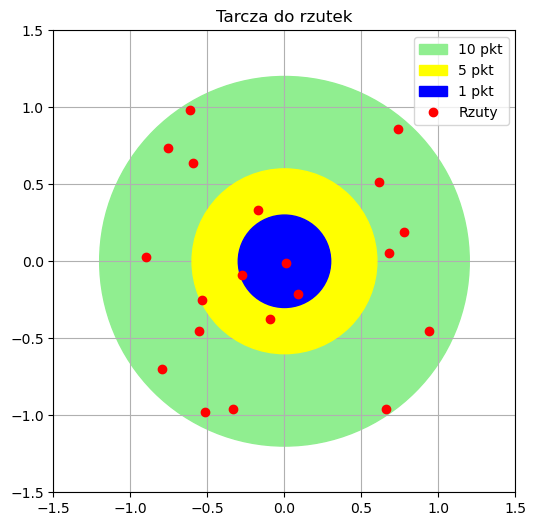

Epizod 50, suma nagród: 61.0


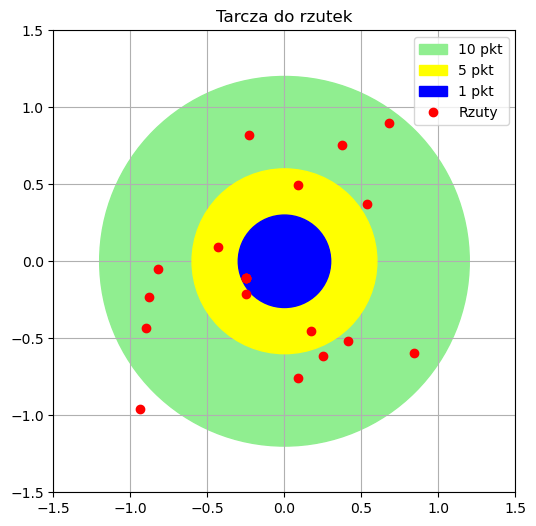

Epizod 100, suma nagród: 77.0


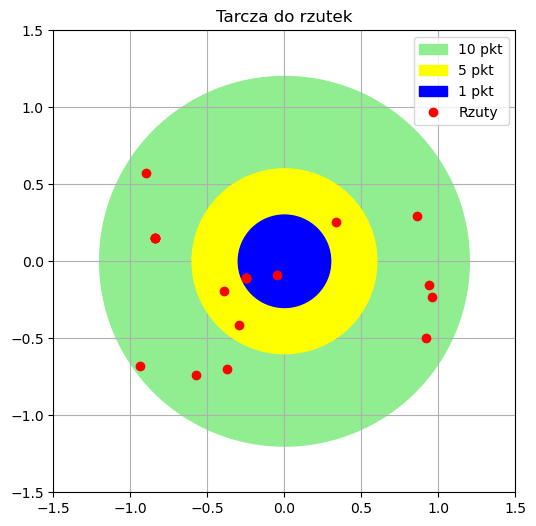

Epizod 150, suma nagród: 64.0


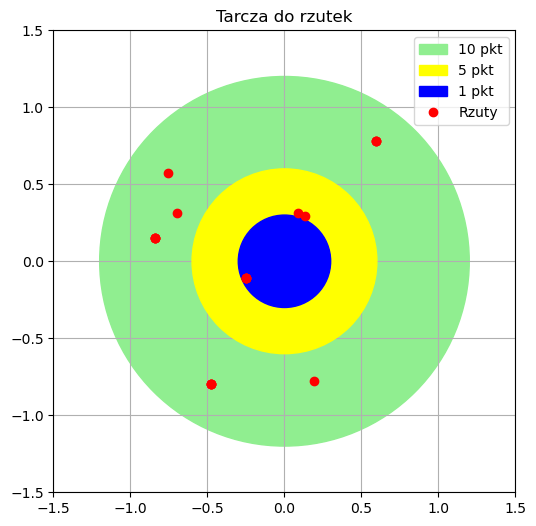

Epizod 200, suma nagród: 70.0


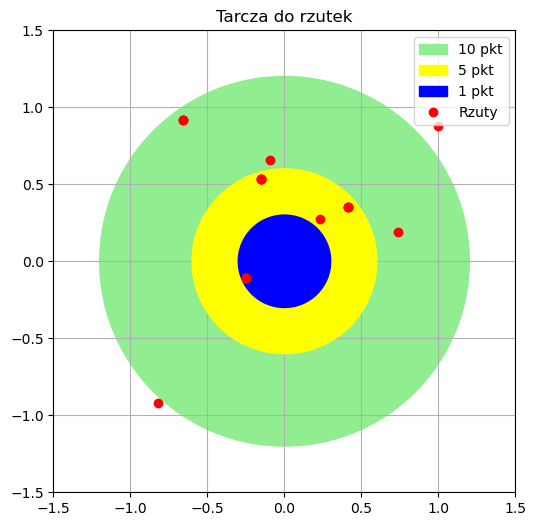

Epizod 250, suma nagród: 163.0


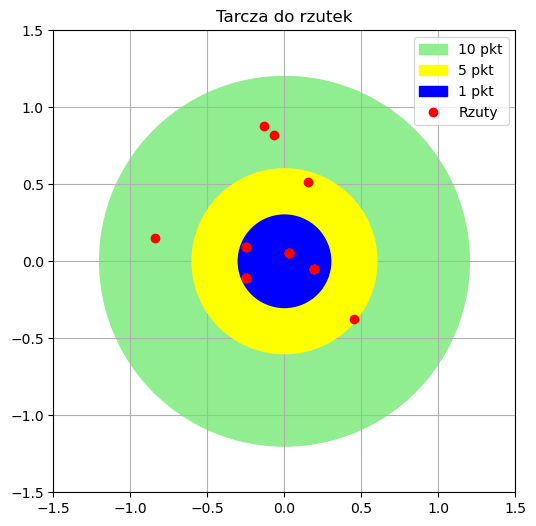

Epizod 300, suma nagród: 173.0


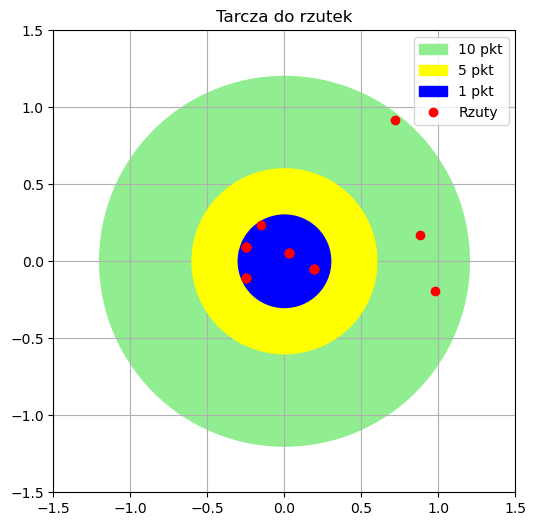

Epizod 350, suma nagród: 186.0


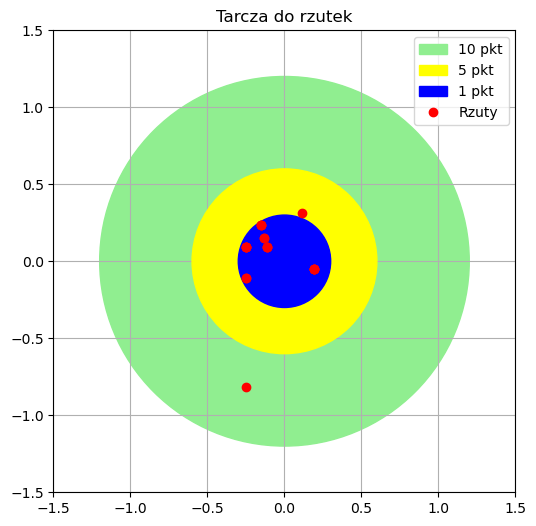

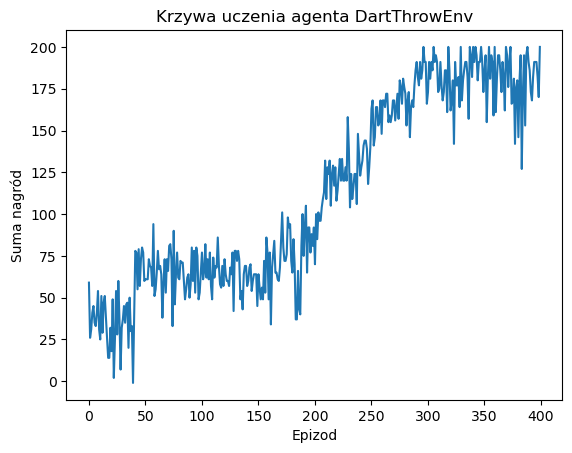

In [6]:
for episode in range(num_episodes):
    state, _ = env.reset()
    state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
    total_reward = 0
    throws_in_episode = []
    throw_counts = defaultdict(int)

    for step in range(num_throws_per_episode):
        if np.random.rand() < epsilon:
            action_idx = np.random.randint(action_size) 
        else:
            with torch.no_grad():
                q_values = q_network(state_tensor)
                action_idx = torch.argmax(q_values).item()

        attempts = 0
        while True:
            action = action_grid[action_idx]
            key = tuple(np.round(action, 3))
            if throw_counts[key] < 4:
                throw_counts[key] += 1
                break
            else:
                if np.random.rand() < epsilon:
                    action_idx = np.random.randint(action_size)
                else:
                    q_values[action_idx] = -float('inf') 
                    action_idx = torch.argmax(q_values).item()

            attempts += 1
            if attempts > 100: 
                break
        throws_in_episode.append(action)
        next_state, reward, done, _, _ = env.step(action)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).to(device)

        with torch.no_grad():
            next_q_values = q_network(next_state_tensor)
            max_next_q = torch.max(next_q_values)
            target_q = reward + discount_factor * max_next_q

        predicted_q = q_network(state_tensor)[action_idx]
        loss = loss_fn(predicted_q, target_q)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state_tensor = next_state_tensor
        total_reward += reward

    epsilon = max(epsilon_min, epsilon * epsilon_decay) 
    rewards_dqn.append(total_reward)

    if episode % 50 == 0:
        print(f"Epizod {episode}, suma nagród: {total_reward}")
        visualize_dartboard_matplotlib(env, throws=throws_in_episode)
    visualize_dartboard_cv2(env, throws=throws_in_episode, wait_time=1000)

env.close()

plt.plot(rewards_dqn, label="DQN (20 rzutów = 1 epizod)")
plt.xlabel('Epizod')
plt.ylabel('Suma nagród')
plt.title('Krzywa uczenia agenta DartThrowEnv')
plt.show()


### Wnioski z treningu agenta DQN

Agent uczy się trafiać w wartościowe obszary tarczy, co potwierdzają:

---

#### Poprawiające się wyniki punktowe

Poniżej widać, jak przykładowo zmieniała się suma zdobytych punktów w wybranych epizodach:

| Epizod | Suma nagród |
|--------|-------------|
| 0      | 59          |
| 50     | 61          |
| 100    | 77          |
| 150    | 64          |
| 200    | 70          |
| 250    | 163         |
| 300    | 173         |
| 350    | 186         |

Na początku agent trafia głównie losowo – suma punktów oscyluje wokół 60–70. Dopiero po pewnym czasie (gdy `epsilon` znacząco spada), agent zaczyna coraz skuteczniej wybierać optymalne rzuty, co skutkuje wzrostem sumy nagród nawet do poziomu ~180 pkt na epizod.

---

#### Skuteczne działanie DQN

- Agent stopniowo uczy się przypisywać wysoką wartość Q dobrym rzutom (tj. bliższym środka tarczy).
- Z czasem przestaje eksplorować losowo, a jego decyzje stają się coraz bardziej trafne.
- Ograniczenie powtórzeń do 4 razy na dany punkt wymusza na nim szersze szukanie strategii

---

#### Krzywa uczenia

Krzywa sumy nagród rośnie z epizodu na epizod, z pewnymi wahaniami (co jest naturalne przy eksploracji). Ostatecznie jednak:
- trend jest wyraźnie rosnący,
- agent stabilnie osiąga wysokie wyniki.

---

#### Obserwacje z wizualizacji

Na wykresach rzutów widać wyraźnie, że:
- na początku agent rzuca w losowe miejsca,
- po kilkuset epizodach koncentruje się na centrum tarczy i maksymalizuje punktację.

---

Podsumowując – agent skutecznie uczy się strategii rzucania w cel, a zastosowana metoda DQN działa zgodnie z oczekiwaniami.
